## Algerian Forest Fires Detection

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
import datetime

In [2]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### Function to read the data

In [3]:
def read_data(data):
    """ Function to read the dataframe and split the data and its labels"""
    Data_read=pd.read_csv(data,header='infer')
    data=Data_read.iloc[:,:-1]
    labels=Data_read.iloc[:,-1]
    return data, labels

### Reading the data

In [4]:
train_data,train_labels=read_data("algerian_fires_train.csv")
test_data,test_labels=read_data('algerian_fires_test.csv')
data_complete=pd.concat([train_data,test_data])
labels_complete=pd.concat([train_labels,test_labels])

In [5]:
data_complete.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI
0,01/06/2012,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,6.225461
1,01/06/2012,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,2.268104
2,02/06/2012,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,-3.327908
3,02/06/2012,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,0.131303
4,03/06/2012,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,-1.928471


### Visualizing the corelation between the features in the training data

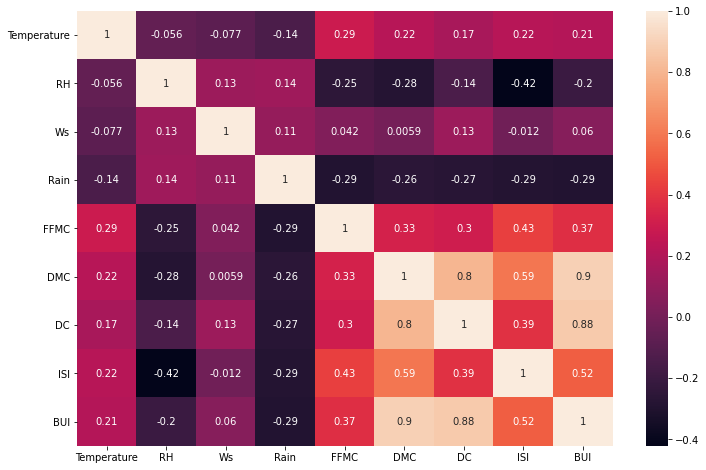

In [6]:
plt.figure(figsize=(12,8))
data_corr=train_data.corr()
sns.heatmap(data_corr,annot=True)
plt.show()

### Plotting the histogram of all the features - (To check on the outliers)

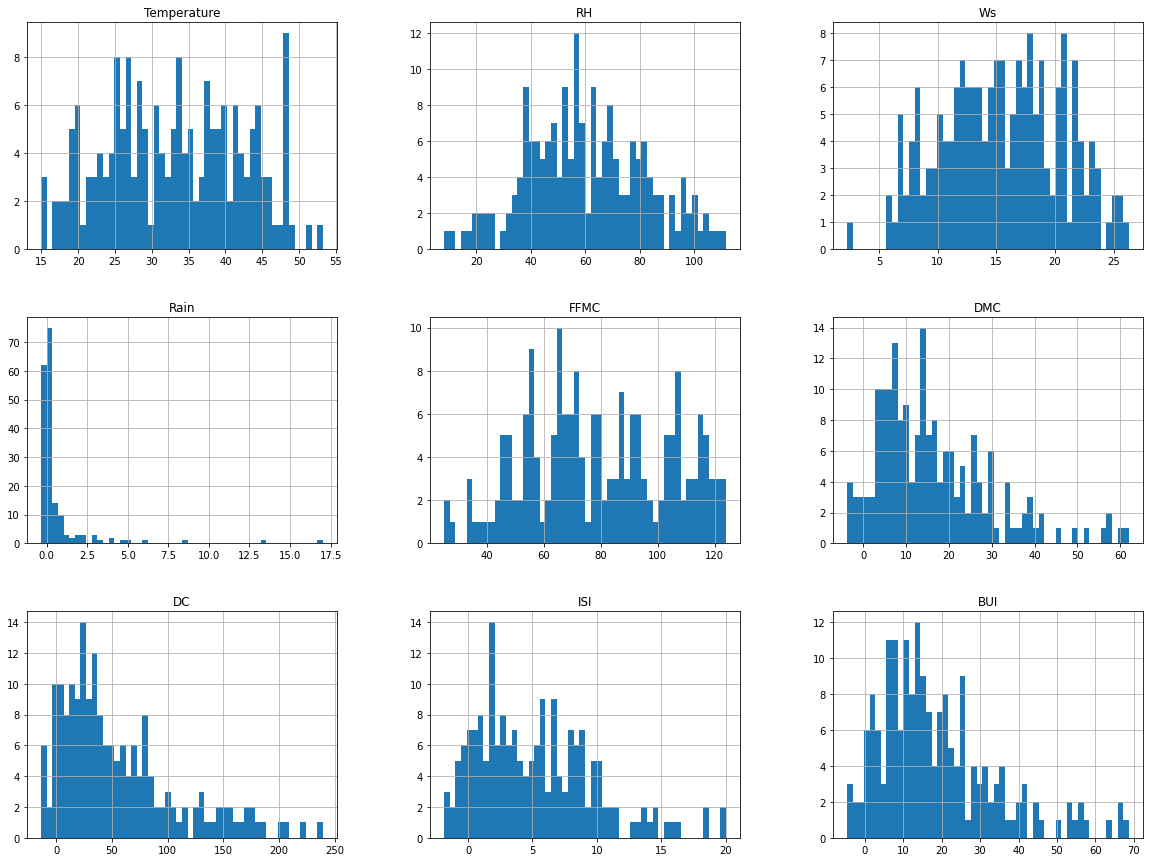

In [7]:
train_data.hist(bins=50,figsize=(20,15))
plt.show()

## Preprocessing the data

#### Adding new features (expanding the feature space) which are quadratic combinations of original features


In [8]:
quadratic_features=PolynomialFeatures()
data_complete_copy=data_complete.copy(deep=True)
data_complete_copy_date=data_complete_copy['Date']
train_feat=data_complete_copy.columns[1:]
data_complete_copy=quadratic_features.fit_transform(data_complete_copy.drop(['Date'],axis=1))
data_complete_copy_features=quadratic_features.get_feature_names(train_feat)
data_complete_copy=pd.DataFrame(data_complete_copy,columns=data_complete_copy_features)
data_complete_copy.insert(0,'Date',list(data_complete_copy_date))

In [9]:
data_complete_copy.head()

,Date,1,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,...,DMC^2,DMC DC,DMC ISI,DMC BUI,DC^2,DC ISI,DC BUI,ISI^2,ISI BUI,BUI^2
0,01/06/2012,1.0,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,...,5.622032,-67.679166,-1.155300,-14.761082,814.735551,13.907732,177.696905,0.237408,3.033329,38.756367
1,01/06/2012,1.0,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,...,0.194483,-4.413386,-0.649225,1.000238,100.152772,14.732822,-22.698354,2.167250,-3.339007,5.144294
2,02/06/2012,1.0,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,...,11.492059,-46.695769,4.538309,-11.281587,189.739265,-18.440544,45.840556,1.792216,-4.455192,11.074970
3,02/06/2012,1.0,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,...,26.828571,-7.214130,-3.911089,0.680101,1.939860,1.051681,-0.182877,0.570161,-0.099146,0.017240
4,03/06/2012,1.0,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,...,5.049746,7.713815,-1.254477,4.333591,11.783354,-1.916295,6.619843,0.311642,-1.076567,3.719002


#### Adding new features to the existing data - Temperature, Rain, RH and WS seem uncorelated with other features, So adding new features which reflect statistics of these features

In [10]:
def add_features(data,feature_num,column_name_1,column_name_2,column_name_3,n):
    """ Function to create new features, which are avg, max and min (operation) of a feature for past n number of days """
    new_feat_avg=[]
    new_feat_max=[]
    new_feat_min=[]
    for i in range(len(data)):
        if (i>=0 and i<2*n):
            new_feat_avg.append(data.iloc[i,feature_num])
            new_feat_max.append(data.iloc[i,feature_num])
            new_feat_min.append(data.iloc[i,feature_num])
        elif (i%2==0):
            new_feat_avg.append(np.mean(data.iloc[i-n*2:i,feature_num]))
            new_feat_avg.append(np.mean(data.iloc[i-n*2:i,feature_num]))
            new_feat_max.append(np.amax(data.iloc[i-n*2:i,feature_num]))
            new_feat_max.append(np.amax(data.iloc[i-n*2:i,feature_num]))
            new_feat_min.append(np.amin(data.iloc[i-n*2:i,feature_num]))
            new_feat_min.append(np.amin(data.iloc[i-n*2:i,feature_num]))
    data[column_name_1]=new_feat_avg
    data[column_name_2]=new_feat_max
    data[column_name_3]=new_feat_min
    return data

In [11]:
def add_statistic_features_to_data(data):
    """ Function which adds statistics of previous days to the given data based on add_features function"""
    data_copy=data.copy(deep=True)
    data_copy=add_features(data_copy,2,'avg_temp_2','max_temp_2','min_temp_2',2)
    data_copy=add_features(data_copy,2,'avg_temp_3','max_temp_3','min_temp_3',3)
    data_copy=add_features(data_copy,5,'avg_rain_2','max_rain_2','min_rain_2',2)
    data_copy=add_features(data_copy,5,'avg_rain_3','max_rain_3','min_rain_3',3)
    data_copy=add_features(data_copy,3,'avg_RH_2','max_RH_2','min_RH_2',2)
    data_copy=add_features(data_copy,3,'avg_RH_3','max_RH_3','min_RH_3',3)
    data_copy=add_features(data_copy,4,'avg_Ws_2','max_Ws_2','min_Ws_2',2)
    data_copy=add_features(data_copy,4,'avg_Ws_3','max_Ws_3','min_Ws_3',3)
    return data_copy

In [12]:
data_copy=data_complete_copy.copy(deep=True)
data_copy=add_statistic_features_to_data(data_copy)

In [13]:
data_copy.head()

,Date,1,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,...,min_RH_2,avg_RH_3,max_RH_3,min_RH_3,avg_Ws_2,max_Ws_2,min_Ws_2,avg_Ws_3,max_Ws_3,min_Ws_3
0,01/06/2012,1.0,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,...,43.855865,43.855865,43.855865,43.855865,12.292536,12.292536,12.292536,12.292536,12.292536,12.292536
1,01/06/2012,1.0,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,...,46.230441,46.230441,46.230441,46.230441,14.838211,14.838211,14.838211,14.838211,14.838211,14.838211
2,02/06/2012,1.0,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,...,57.084279,57.084279,57.084279,57.084279,10.968696,10.968696,10.968696,10.968696,10.968696,10.968696
3,02/06/2012,1.0,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,...,99.910000,99.910000,99.910000,99.910000,17.924025,17.924025,17.924025,17.924025,17.924025,17.924025
4,03/06/2012,1.0,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,...,43.855865,104.398680,104.398680,104.398680,14.005867,17.924025,10.968696,23.740540,23.740540,23.740540


### Data Normalization using Standard Scaler (Standardization)

In [14]:
def Scale_feature(data, data_columns,Scaletype):
    """ Function which performs Standardization scaling of all the columns (except the date column) """
    data_date=data['Date']
    data=data.drop(columns='Date')
    data=Scaletype.fit_transform(data)
    data=pd.DataFrame(data,columns=data_columns[1:])
    data.insert(0,'Date',data_date)
    return data

In [15]:
data_train=data_copy[:184]
train_data_normalized=Scale_feature(data_train,data_train.columns,StandardScaler())
data_test=data_copy[184:]
test_data_normalized=Scale_feature(data_test,data_test.columns,StandardScaler())
test_data_normalized.drop(['1'],axis=1);


#### Dropping last 3 dates in train set because they influence the test set

In [16]:
train_data_normalized.drop(train_data_normalized.tail(6).index,inplace=True)
train_data_normalized=train_data_normalized.drop(['1'],axis=1)
train_data_normalized.head()
train_labels.drop(train_labels.tail(6).index,inplace=True)

### Performing the splitting of data into 5 folds for Cross validation

In [17]:
def cv_split(data,start_date_train_1,end_date_train_1,start_date_val, end_date_val,start_date_train_2,end_date_train_2):
    """ Function to split data into validation fold and training folds based on its start and end dates """
    data_copy=data.copy(deep=True)
    data_copy.set_index('Date',inplace=True)
    validation=data_copy[start_date_val:end_date_val]
    train_data_1=data_copy[start_date_train_1:end_date_train_1]
    train_data_2=data_copy[start_date_train_2:end_date_train_2]
    train_data=pd.concat([train_data_1,train_data_2])
    return train_data, validation

#### Splitting the data based on dates

In [18]:
train_start_dates_1=['19/06/2012','01/06/2012','01/06/2012','01/06/2012','01/06/2012']
train_end_dates_1=['31/07/2012','15/06/2012','03/07/2012','21/07/2012','31/07/2012']
val_start_date=['01/06/2012','19/06/2012','07/07/2012','25/07/2012','12/08/2012']
val_end_date=['15/06/2012','03/07/2012','21/07/2012','08/08/2012','28/08/2012']
train_start_dates_2=['01/08/2012','07/07/2012','25/07/2012','12/08/2012','01/08/2012']
train_end_dates_2=['28/08/2012','28/08/2012','28/08/2012','28/08/2012','08/08/2012']

### Feature selection and reduction - Performing PCA to get the best feature set

#### Principal Components Analysis-PCA

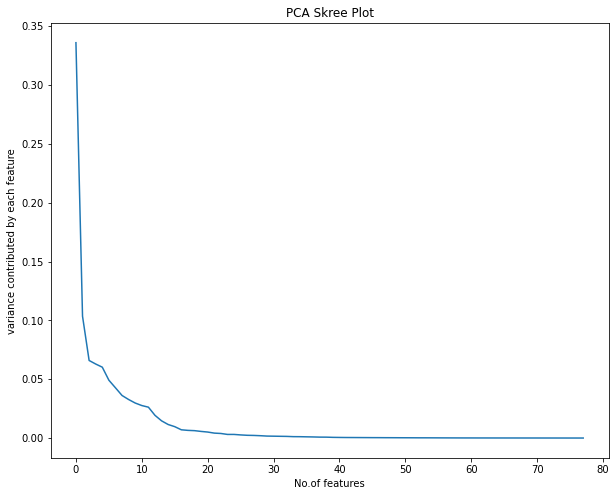

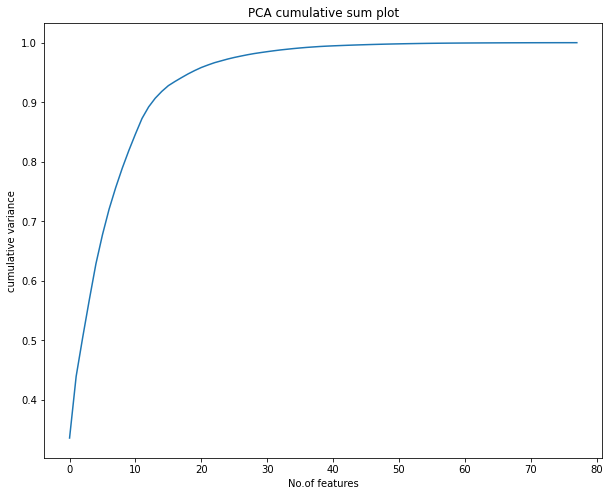

Cumulative sum of variance list: [0.33597198 0.43949852 0.50541352 0.56830327 0.62852121 0.67766541
 0.72034456 0.75649819 0.78922098 0.81896195 0.8465727  0.87279899
 0.89208207 0.90669157 0.91818055 0.92784366 0.93484008 0.94135569
 0.94762457 0.95324347 0.95833075 0.9625161  0.96639422 0.96946204
 0.97252494 0.97517239 0.97750344 0.97971481 0.98169428 0.98335733
 0.98492919 0.9864076  0.98780038 0.9889796  0.99012274 0.9911534
 0.99207533 0.99285184 0.99360422 0.99418666 0.99469217 0.99514067
 0.99556647 0.99596197 0.99633359 0.99667181 0.99699606 0.99728794
 0.99756629 0.99781919 0.99805231 0.99827    0.99845681 0.99863915
 0.99881051 0.99895604 0.99908351 0.99919359 0.99928687 0.99936757
 0.99944341 0.99950933 0.99957229 0.99962963 0.99968053 0.99972792
 0.99977374 0.99981295 0.99984911 0.99988196 0.99991239 0.99993511
 0.99995408 0.99996977 0.99998387 0.99999191 0.99999736 1.        ]


In [19]:
pca_full=PCA()
pca_full.fit(train_data_normalized[train_data_normalized.columns.difference(['Date'])])
plt.figure(figsize=(10,8))
plt.title("PCA Skree Plot")
plt.xlabel('No.of features')
plt.ylabel('variance contributed by each feature')
plt.plot(pca_full.explained_variance_ratio_)
plt.show()
plt.figure(figsize=(10,8))
plt.title("PCA cumulative sum plot")
plt.ylabel('cumulative variance')
plt.xlabel('No.of features')
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.show()
print('Cumulative sum of variance list: {0}'.format(np.cumsum(pca_full.explained_variance_ratio_)))

#### Running the PCA on training data for no.of components selected ranging from 6 to 20 on all the models and choosing the best one among them based on cross validation accuracy and F1 score

In [20]:
def PCA_transform(data, no_of_components,date_column):
    """ Function to perform PCA transformation on data based on no.of components"""
    pca=PCA(n_components=no_of_components)
    train_data_PCA=pca.fit_transform(data[data.columns.difference(['Date'])])
    train_data_PCA_df=pd.DataFrame(train_data_PCA)
    # Adding date column to transformed dataframe
    train_data_PCA_df.insert(0,'Date',list(date_column))
    return train_data_PCA_df


def PCA_select_components(data,no_of_comp,labels):
    """ Function to split data into folds based on no.of components given for PCA"""
    K_fold_split_pca=[]
    train_data_PCA_df=PCA_transform(data,no_of_comp,data['Date'])
    train_data_PCA_df['Classes']=labels
    for i in range(len(train_start_dates_1)):
        # For features obtained from pca
        train_pca,val_pca=cv_split(train_data_PCA_df,train_start_dates_1[i],train_end_dates_1[i],val_start_date[i],val_end_date[i],train_start_dates_2[i],train_end_dates_2[i])
        K_fold_split_pca.append([train_pca,val_pca])
    return K_fold_split_pca

#### Defining a function which trains all the required Models

In [21]:
def Models_train(data,Model,Kernel='linear',no_of_neighbours=5,Hidden_layer_sizes=(50),C_val=1,Gamma=0.1):
    """ Function which trains the Models on data """
    if(Model==SVC):
        model=SVC(kernel=Kernel,gamma=Gamma,C=C_val)
    elif(Model==MLPClassifier):
        model=MLPClassifier(hidden_layer_sizes=Hidden_layer_sizes,max_iter=700,random_state=42)
    elif(Model==KNeighborsClassifier):
        model=Model(n_neighbors=no_of_neighbours)
    elif(Model==LogisticRegression):
        model=Model(C=C_val)
    else:
        model= Model()
    val_accuracies=[]
    val_f1_scores=[]
    for i in range(len(data)):
        train_labels=data[i][0]['Classes']
        data[i][0]=data[i][0].drop(['Classes'],axis=1)
        model.fit(data[i][0],train_labels)
        val_labels=data[i][1]['Classes']
        val_pred=model.predict(data[i][1].drop(['Classes'],axis=1))
        val_accuracies.append(accuracy_score(val_labels,val_pred))
        val_f1_scores.append(f1_score(val_labels,val_pred,average=None))
        data[i][0]['Classes']=train_labels
        data[i][1]['Classes']=val_labels
    return np.mean(val_accuracies)*100,np.mean(val_f1_scores,axis=0),np.mean(np.mean(val_f1_scores,axis=0))

#### Training the models upon changing the number of components chosen by PCA

#### Training the Linear Perceptron Model on components [ranging from (6,21)] obtained from PCA

In [22]:
def train_models_initial(data,Model,Model_str,hidden_layer_size=(50)):
    """ Function for Training Perceptron, Random Forests, ANN, Bayes Classifier and Ridge Classifier """
    np.warnings.filterwarnings('ignore')
    accuracy_list=[]
    accuracy_max=0
    mean_f1_max=0
    comp_max=0
    for i in range(6,23):
        K_fold_split_pca=PCA_select_components(data,i,train_labels)
        accuracy,f1,mean_f1=Models_train(K_fold_split_pca,Model,Hidden_layer_sizes= hidden_layer_size)
        print("The accuracy and mean F1 score for {0} PCA components with {1} Model is {2} and {3} ".format(i,Model_str,accuracy,mean_f1))
        if(accuracy>accuracy_max):
            accuracy_max=accuracy
            mean_f1_max=mean_f1
            comp_max=i
        accuracy_list.append(accuracy)
    print("The maximum accuracy and corresponding mean F1 score using {0} is obtained for {1} number of components. The accuracy is {2} and corresponding mean F1 score is {3} ".format(Model_str,comp_max,accuracy_max,mean_f1_max))
    return accuracy_list

In [23]:
train_data_normalized.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,...,min_RH_2,avg_RH_3,max_RH_3,min_RH_3,avg_Ws_2,max_Ws_2,min_Ws_2,avg_Ws_3,max_Ws_3,min_Ws_3
0,01/06/2012,-1.534072,-0.764223,-0.623726,-0.501390,-0.254701,-1.403548,-0.495937,-1.044898,-0.818950,...,0.219779,-1.376236,-2.877006,0.429854,-1.100406,-2.344685,0.513306,-1.322015,-3.003211,0.827868
1,01/06/2012,0.159064,-0.654173,-0.117613,0.164341,-0.947489,-1.192354,-1.222222,-1.476594,-1.080362,...,0.375843,-1.179731,-2.720148,0.579807,-0.177057,-1.599278,1.252148,-0.234886,-2.172172,1.597474
2,02/06/2012,-1.936356,-0.151150,-0.886922,0.402691,-1.879308,-0.970877,-1.293189,-0.857297,-1.450018,...,1.089188,-0.281540,-2.003176,1.265218,-1.580580,-2.732323,0.129083,-1.887360,-3.435381,0.427647
3,02/06/2012,-0.891990,1.833614,0.495886,1.734587,-2.162569,-0.836471,-1.059923,-1.318610,-1.221512,...,3.903818,3.262432,0.825765,3.969628,0.942207,-0.695710,2.147757,1.082910,-1.164803,2.530373
4,03/06/2012,-1.487368,2.041643,1.652283,6.642462,-2.060535,-1.394242,-1.098353,-1.029254,-1.357575,...,0.219779,3.633885,1.122273,4.253085,-0.478959,-0.695710,0.129083,3.566850,0.734008,4.288815


In [24]:
accuracy_variation_Perceptron=train_models_initial(train_data_normalized,Perceptron,'Perceptron')

The accuracy and mean F1 score for 6 PCA components with Perceptron Model is 84.90196078431373 and 0.786312975996108 
The accuracy and mean F1 score for 7 PCA components with Perceptron Model is 84.82352941176471 and 0.7902586009922967 
The accuracy and mean F1 score for 8 PCA components with Perceptron Model is 80.15686274509804 and 0.6865048843309713 
The accuracy and mean F1 score for 9 PCA components with Perceptron Model is 84.07843137254902 and 0.7894954332502471 
The accuracy and mean F1 score for 10 PCA components with Perceptron Model is 84.23529411764706 and 0.7807614219605724 
The accuracy and mean F1 score for 11 PCA components with Perceptron Model is 86.07843137254902 and 0.8151758535582064 
The accuracy and mean F1 score for 12 PCA components with Perceptron Model is 88.15686274509804 and 0.8345602776852777 
The accuracy and mean F1 score for 13 PCA components with Perceptron Model is 84.23529411764706 and 0.7887324903386284 
The accuracy and mean F1 score for 14 PCA com

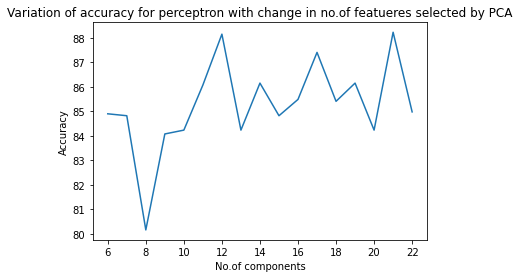

In [25]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,accuracy_variation_Perceptron)
plt.title("Variation of accuracy for perceptron with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

### Training The Naive Bayes classifier with assumption of pdf of features as Gaussian distributed to check performance on validation set

In [26]:
accuracy_variation_Bayes=train_models_initial(train_data_normalized,GaussianNB,'Bayes Classifier')

The accuracy and mean F1 score for 6 PCA components with Bayes Classifier Model is 86.07843137254902 and 0.8254008249916178 
The accuracy and mean F1 score for 7 PCA components with Bayes Classifier Model is 84.07843137254902 and 0.8032112744496647 
The accuracy and mean F1 score for 8 PCA components with Bayes Classifier Model is 85.41176470588235 and 0.8143912448061055 
The accuracy and mean F1 score for 9 PCA components with Bayes Classifier Model is 84.82352941176471 and 0.7432724300443359 
The accuracy and mean F1 score for 10 PCA components with Bayes Classifier Model is 84.74509803921568 and 0.8089452770331882 
The accuracy and mean F1 score for 11 PCA components with Bayes Classifier Model is 83.41176470588236 and 0.7924435389172231 
The accuracy and mean F1 score for 12 PCA components with Bayes Classifier Model is 81.41176470588235 and 0.7751977911598442 
The accuracy and mean F1 score for 13 PCA components with Bayes Classifier Model is 83.41176470588235 and 0.78880119880119

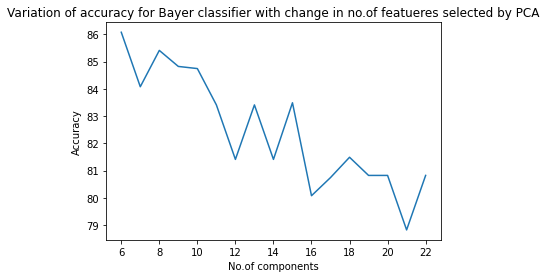

In [27]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,accuracy_variation_Bayes)
plt.title("Variation of accuracy for Bayer classifier with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

#### Training the Logistic Regression Model on components [ranging from (6,21)] obtained from PCA by varying the C (regularization parameter value)

In [28]:
def train_models_logistic(data,Model,Model_str):
    """ Function to train logistic model for various C values"""
    np.warnings.filterwarnings('ignore')
    accuracy_max=0
    mean_f1_max=0
    comp_max=0
    c_max=0
    C_list=[0.05, 0.1, 0.7, 1,5,10]
    for i in range(6,22):
        for c in C_list:
            K_fold_split_pca=PCA_select_components(data,i,train_labels)
            accuracy,f1,mean_f1=Models_train(K_fold_split_pca,Model)
            print("The accuracy and mean F1 score for {0} PCA components with {1} Model with C as {2} is {3} and {4} ".format(i,Model_str, c,accuracy,mean_f1))
            if(accuracy>accuracy_max):
                accuracy_max=accuracy
                mean_f1_max=mean_f1
                comp_max=i
                c_max=c
    print("The maximum accuracy and corresponding mean F1 score using {0} with C as {1} is obtained for {2} number of components. The accuracy is {3} and corresponding mean F1 score is {4} ".format(Model_str,c_max,comp_max,accuracy_max,mean_f1_max))

In [29]:
train_models_logistic(train_data_normalized,LogisticRegression,'Logistic Regression')

The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 0.05 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 0.1 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 0.7 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 1 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 5 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 6 PCA components with Logistic Regression Model with C as 10 is 90.07843137254902 and 0.863167480993568 
The accuracy and mean F1 score for 7 PCA components with Logistic Regression Model with C as 0.05 is 89.41176470588236 and 0.8565374443635313 
The accuracy an

The accuracy and mean F1 score for 15 PCA components with Logistic Regression Model with C as 10 is 86.15686274509805 and 0.8088125026627915 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 0.05 is 87.41176470588236 and 0.8342992387729229 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 0.1 is 87.41176470588236 and 0.8342992387729229 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 0.7 is 87.41176470588236 and 0.8342992387729229 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 1 is 87.41176470588236 and 0.8342992387729229 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 5 is 87.41176470588236 and 0.8342992387729229 
The accuracy and mean F1 score for 16 PCA components with Logistic Regression Model with C as 10 is 87.41176470588236 and 0.8342992387729229 
The 

#### Training the K-Nearest Neighbours Model on components [ranging from (6,21)] obtained from PCA by varying the no.of neighbours

In [30]:
def train_models_KNN(data,Model,Model_str):
    """ Function to train KNN for different number of neighbors"""
    np.warnings.filterwarnings('ignore')
    accuracy_max=0
    mean_f1_max=0
    comp_max=0
    n_max=0
    neighbour_list=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    for i in range(6,22):
        for neighbours in neighbour_list:
            K_fold_split_pca=PCA_select_components(data,i,train_labels)
            accuracy,f1,mean_f1=Models_train(K_fold_split_pca,Model)
            print("The accuracy and mean F1 score for {0} PCA components with {1} Model with No.of neighbours as {2} is {3} and {4} ".format(i,Model_str, neighbours,accuracy,mean_f1))
            if(accuracy>accuracy_max):
                accuracy_max=accuracy
                mean_f1_max=mean_f1
                comp_max=i
                n_max=neighbours
    print("The maximum accuracy and corresponding mean F1 score using {0} with No.of neighbours as {1} is obtained for {2} number of components. The accuracy is {3} and corresponding mean F1 score is {4} ".format(Model_str,n_max,comp_max,accuracy_max,mean_f1_max))

In [31]:
train_models_KNN(train_data_normalized,KNeighborsClassifier,'K-Nearest Neighbors')

The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 3 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 4 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 5 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 6 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 7 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Neighbors Model with No.of neighbours as 8 is 85.41176470588235 and 0.8107638852375694 
The accuracy and mean F1 score for 6 PCA components with K-Nearest Nei

The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 7 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 8 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 9 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 10 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 11 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighbors Model with No.of neighbours as 12 is 84.15686274509804 and 0.740075146919553 
The accuracy and mean F1 score for 9 PCA components with K-Nearest Neighb

The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 12 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 13 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 14 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 15 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 16 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with K-Nearest Neighbors Model with No.of neighbours as 17 is 83.49019607843138 and 0.7734864283662423 
The accuracy and mean F1 score for 12 PCA components with 

The accuracy and mean F1 score for 15 PCA components with K-Nearest Neighbors Model with No.of neighbours as 17 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 15 PCA components with K-Nearest Neighbors Model with No.of neighbours as 18 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 15 PCA components with K-Nearest Neighbors Model with No.of neighbours as 19 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 16 PCA components with K-Nearest Neighbors Model with No.of neighbours as 3 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 16 PCA components with K-Nearest Neighbors Model with No.of neighbours as 4 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 16 PCA components with K-Nearest Neighbors Model with No.of neighbours as 5 is 84.90196078431373 and 0.7848834498834499 
The accuracy and mean F1 score for 16 PCA components with K-N

The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 9 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 10 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 11 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 12 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 13 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K-Nearest Neighbors Model with No.of neighbours as 14 is 82.82352941176472 and 0.7631328930127069 
The accuracy and mean F1 score for 19 PCA components with K

#### Training the Random Forests Model on components [ranging from (6,21)] obtained from PCA 

In [32]:
Accuracy_list_Random_forests=train_models_initial(train_data_normalized,RandomForestClassifier,'Random Forests')

The accuracy and mean F1 score for 6 PCA components with Random Forests Model is 87.41176470588235 and 0.828130399012752 
The accuracy and mean F1 score for 7 PCA components with Random Forests Model is 87.5686274509804 and 0.7748012164154435 
The accuracy and mean F1 score for 8 PCA components with Random Forests Model is 88.23529411764707 and 0.7847755360750905 
The accuracy and mean F1 score for 9 PCA components with Random Forests Model is 88.31372549019608 and 0.8216764681660318 
The accuracy and mean F1 score for 10 PCA components with Random Forests Model is 86.98039215686275 and 0.7742477168020647 
The accuracy and mean F1 score for 11 PCA components with Random Forests Model is 89.49019607843137 and 0.7933079187251203 
The accuracy and mean F1 score for 12 PCA components with Random Forests Model is 88.82352941176471 and 0.8350423881673883 
The accuracy and mean F1 score for 13 PCA components with Random Forests Model is 88.90196078431373 and 0.8298195061238539 
The accuracy a

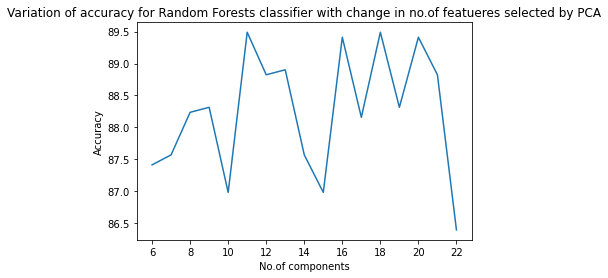

In [33]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,Accuracy_list_Random_forests)
plt.title("Variation of accuracy for Random Forests classifier with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

#### Training Neural Network Classifier to check performance on validation set (Model selection with different neural network architectures)

##### Architecture of 1 hidden layer with 40 units in the hidden layer

In [34]:
NN_acc_1=train_models_initial(train_data_normalized,MLPClassifier,'Neural Network',hidden_layer_size=(40))

The accuracy and mean F1 score for 6 PCA components with Neural Network Model is 86.8235294117647 and 0.7643905380907728 
The accuracy and mean F1 score for 7 PCA components with Neural Network Model is 86.23529411764706 and 0.805312965139052 
The accuracy and mean F1 score for 8 PCA components with Neural Network Model is 86.15686274509804 and 0.8084389584760532 
The accuracy and mean F1 score for 9 PCA components with Neural Network Model is 84.31372549019608 and 0.7838943893741266 
The accuracy and mean F1 score for 10 PCA components with Neural Network Model is 82.90196078431373 and 0.7709592636114375 
The accuracy and mean F1 score for 11 PCA components with Neural Network Model is 80.23529411764706 and 0.7372398846339796 
The accuracy and mean F1 score for 12 PCA components with Neural Network Model is 81.05882352941177 and 0.7486051032477861 
The accuracy and mean F1 score for 13 PCA components with Neural Network Model is 81.6470588235294 and 0.7571992498253284 
The accuracy an

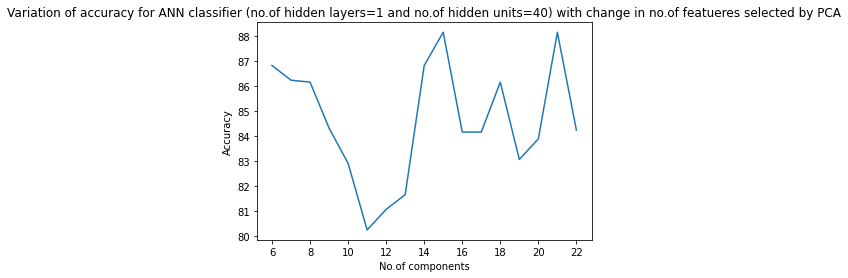

In [35]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,NN_acc_1)
plt.title("Variation of accuracy for ANN classifier (no.of hidden layers=1 and no.of hidden units=40) with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

##### Architecture of 2 hidden layer with (50,10) units in the hidden layer

In [36]:
NN_acc_2=train_models_initial(train_data_normalized,MLPClassifier,'Neural Network',hidden_layer_size=(50,10))

The accuracy and mean F1 score for 6 PCA components with Neural Network Model is 83.49019607843138 and 0.7281550235110608 
The accuracy and mean F1 score for 7 PCA components with Neural Network Model is 86.8235294117647 and 0.8169498699009569 
The accuracy and mean F1 score for 8 PCA components with Neural Network Model is 84.82352941176471 and 0.7956272302259144 
The accuracy and mean F1 score for 9 PCA components with Neural Network Model is 82.90196078431373 and 0.770968712900063 
The accuracy and mean F1 score for 10 PCA components with Neural Network Model is 84.90196078431373 and 0.7929646844383686 
The accuracy and mean F1 score for 11 PCA components with Neural Network Model is 83.56862745098039 and 0.7749031014627934 
The accuracy and mean F1 score for 12 PCA components with Neural Network Model is 84.23529411764706 and 0.7822565738355213 
The accuracy and mean F1 score for 13 PCA components with Neural Network Model is 82.23529411764707 and 0.7584854523161817 
The accuracy a

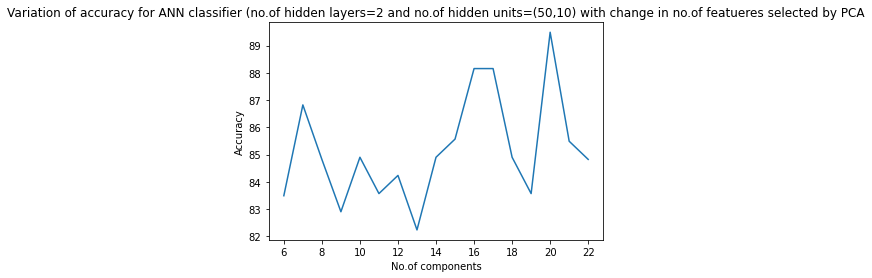

In [37]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,NN_acc_2)
plt.title("Variation of accuracy for ANN classifier (no.of hidden layers=2 and no.of hidden units=(50,10) with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

##### Architecture of 2 hidden layer (35, 15) units

In [38]:
NN_acc_3=train_models_initial(train_data_normalized,MLPClassifier,'Neural Network',hidden_layer_size=(35,15))

The accuracy and mean F1 score for 6 PCA components with Neural Network Model is 83.49019607843138 and 0.7309197994987467 
The accuracy and mean F1 score for 7 PCA components with Neural Network Model is 87.33333333333334 and 0.8657891556152426 
The accuracy and mean F1 score for 8 PCA components with Neural Network Model is 85.49019607843137 and 0.8036897966408836 
The accuracy and mean F1 score for 9 PCA components with Neural Network Model is 88.82352941176471 and 0.8399718479229348 
The accuracy and mean F1 score for 10 PCA components with Neural Network Model is 82.3921568627451 and 0.762589633183319 
The accuracy and mean F1 score for 11 PCA components with Neural Network Model is 82.23529411764707 and 0.7531749176922755 
The accuracy and mean F1 score for 12 PCA components with Neural Network Model is 86.23529411764706 and 0.8000801245538087 
The accuracy and mean F1 score for 13 PCA components with Neural Network Model is 82.47058823529413 and 0.7550331062160609 
The accuracy a

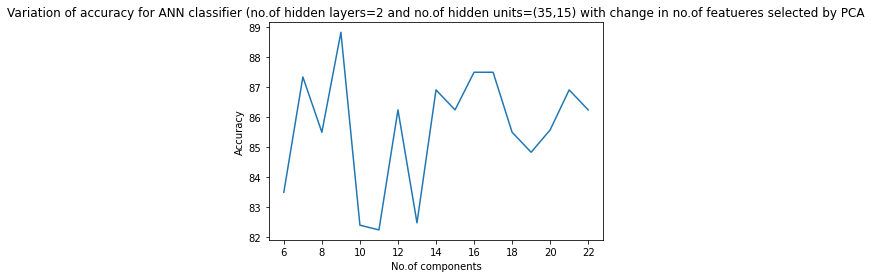

In [39]:
range_val=[i for i in range(6,23)]
plt.plot(range_val,NN_acc_3)
plt.title("Variation of accuracy for ANN classifier (no.of hidden layers=2 and no.of hidden units=(35,15) with change in no.of featueres selected by PCA")
plt.xlabel("No.of components")
plt.ylabel("Accuracy")
plt.show()

#### Training the Ridge classifier on pca components ranging from 6 to 21 

In [40]:
Ridge=train_models_initial(train_data_normalized,RidgeClassifier,'Ridge Classifier',hidden_layer_size=(35,15))

The accuracy and mean F1 score for 6 PCA components with Ridge Classifier Model is 88.15686274509804 and 0.8304043876054745 
The accuracy and mean F1 score for 7 PCA components with Ridge Classifier Model is 88.07843137254903 and 0.8428717490547039 
The accuracy and mean F1 score for 8 PCA components with Ridge Classifier Model is 87.41176470588236 and 0.8328713835966726 
The accuracy and mean F1 score for 9 PCA components with Ridge Classifier Model is 86.90196078431373 and 0.8079357207999478 
The accuracy and mean F1 score for 10 PCA components with Ridge Classifier Model is 84.90196078431373 and 0.789497322852586 
The accuracy and mean F1 score for 11 PCA components with Ridge Classifier Model is 85.49019607843137 and 0.7979541989052858 
The accuracy and mean F1 score for 12 PCA components with Ridge Classifier Model is 82.90196078431373 and 0.7667812746073616 
The accuracy and mean F1 score for 13 PCA components with Ridge Classifier Model is 83.56862745098039 and 0.773063325889412

#### Training the SVM with Linear, polynomial Kernel and RBF Kernel on pca components ranging from 6 to 21 for various values of C (regularization) and Gamma (Kernel coefficient)

In [41]:
def train_models_SVM(data):
    """ Function to train SVM """
    np.warnings.filterwarnings('ignore')
    g_list=[0.0001,0.0005,0.001,0.01,0.1,1]
    C_list=[0.0001,0.001,0.01,0.1,1,10,100,500]
    Kernel_list=['linear','poly','rbf']
    accuracy_max_list=[]
    accuracy_max=0
    f1_max=0
    c_max=0
    gamma_max=0
    comp_max=0
    kernel_max=0
    for i in range(6,22):
        K_fold_split_pca=PCA_select_components(data,i,train_labels)
        for kernel in Kernel_list:
            for gamma in g_list:
                for c in C_list:
                    accuracy,f1,mean_f1=Models_train(K_fold_split_pca,SVC,Kernel=kernel,C_val=c,Gamma=gamma)
                    print("The accuracy for {0} PCA components with {1} Kernel for gamma as {2} and C as {3} is {4}".format(i,kernel,gamma,c,accuracy))
                    if(accuracy>accuracy_max):
                        accuracy_max=accuracy
                        c_max=c
                        gamma_max=gamma
                        comp_max=i
                        kernel_max=kernel
                        f1_max=mean_f1
    accuracy_max_list.append([c_max,gamma_max,comp_max,accuracy_max])
    print("The maximum accuracy using SVM is obtained for {0} number of components using {1} Kernel with C as {2} and gamma as {3}. The accuracy is {4} and corresponding f1 score is {5}".format(comp_max,kernel_max,c_max,gamma_max,accuracy_max,f1_max))


In [42]:
train_models_SVM(train_data_normalized)

The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 0.001 is 76.07843137254903
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 0.01 is 90.74509803921569
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 0.1 is 90.07843137254902
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 1 is 90.07843137254902
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 10 is 88.74509803921569
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 100 is 88.74509803921569
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0001 and C as 500 is 88.74509803921569
The accuracy for 6 PCA components with linear Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for 6 PCA components

The accuracy for 6 PCA components with poly Kernel for gamma as 0.1 and C as 10 is 76.66666666666666
The accuracy for 6 PCA components with poly Kernel for gamma as 0.1 and C as 100 is 76.23529411764706
The accuracy for 6 PCA components with poly Kernel for gamma as 0.1 and C as 500 is 76.23529411764706
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 0.0001 is 90.0
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 0.001 is 84.00000000000001
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 0.01 is 76.66666666666666
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 0.1 is 76.23529411764706
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 1 is 76.23529411764706
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 10 is 76.23529411764706
The accuracy for 6 PCA components with poly Kernel for gamma as 1 and C as 100 is 76.23529411764706
The a

The accuracy for 7 PCA components with linear Kernel for gamma as 0.001 and C as 100 is 88.74509803921569
The accuracy for 7 PCA components with linear Kernel for gamma as 0.001 and C as 500 is 88.74509803921569
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 0.0001 is 62.8235294117647
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 0.001 is 76.07843137254902
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 0.01 is 90.74509803921569
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 0.1 is 89.41176470588236
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 1 is 89.41176470588236
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 10 is 88.74509803921569
The accuracy for 7 PCA components with linear Kernel for gamma as 0.01 and C as 100 is 88.74509803921569
The accuracy for 7 PCA components with linear Kerne

The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 0.1 is 62.8235294117647
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 1 is 88.07843137254903
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 10 is 89.41176470588236
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 100 is 88.74509803921569
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.001 and C as 500 is 91.41176470588235
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.01 and C as 0.0001 is 62.8235294117647
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.01 and C as 0.001 is 62.8235294117647
The accuracy for 7 PCA components with rbf Kernel for gamma as 0.01 and C a

The accuracy for 8 PCA components with poly Kernel for gamma as 0.0005 and C as 10 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.0005 and C as 100 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.0005 and C as 500 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 0.1 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 1 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.001 and C as 10 is 62.8235294117647
The accuracy for 8 PCA components with poly Kernel for gamma as 0.00

The accuracy for 9 PCA components with linear Kernel for gamma as 0.0001 and C as 1 is 88.74509803921568
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0001 and C as 10 is 88.74509803921568
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0001 and C as 100 is 88.74509803921568
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0001 and C as 500 is 88.74509803921568
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0005 and C as 0.001 is 76.74509803921569
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0005 and C as 0.01 is 90.74509803921569
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0005 and C as 0.1 is 89.41176470588236
The accuracy for 9 PCA components with linear Kernel for gamma as 0.0005 and C as 1 is 88.74509803921568
The accuracy for 9 PCA components wit

The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 0.0001 is 84.74509803921568
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 0.001 is 84.74509803921568
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 0.01 is 82.15686274509804
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 0.1 is 82.15686274509804
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 1 is 82.15686274509804
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 10 is 82.15686274509804
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 100 is 82.15686274509804
The accuracy for 9 PCA components with poly Kernel for gamma as 1 and C as 500 is 82.15686274509804
The accuracy for 9 PCA components with rbf Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for 9 PCA components with rbf Kernel for gamma as 0.0001 and C as 0.001 is 62.

The accuracy for 10 PCA components with linear Kernel for gamma as 0.01 and C as 100 is 87.41176470588235
The accuracy for 10 PCA components with linear Kernel for gamma as 0.01 and C as 500 is 87.41176470588235
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 0.0001 is 62.8235294117647
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 0.001 is 76.74509803921569
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 0.01 is 90.8235294117647
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 0.1 is 88.74509803921568
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 1 is 88.078431372549
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 10 is 86.74509803921569
The accuracy for 10 PCA components with linear Kernel for gamma as 0.1 and C as 100 is 87.41176470588235
The accuracy for 10 PCA components with linear Kernel 

The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 0.1 is 62.8235294117647
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 1 is 86.74509803921569
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 10 is 90.07843137254902
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 100 is 88.15686274509802
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.001 and C as 500 is 87.56862745098039
The accuracy for 10 PCA components with rbf Kernel for gamma as 0.01 and C as 0.0001 is 62.8235294117647
The accuracy for 10 PCA components with rbf Kernel for gamma as 

The accuracy for 11 PCA components with linear Kernel for gamma as 1 and C as 500 is 88.74509803921569
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 0.001 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 0.01 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 0.1 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 1 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 10 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 100 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel for gamma as 0.0001 and C as 500 is 62.8235294117647
The accuracy for 11 PCA components with poly Kernel fo

The accuracy for 11 PCA components with rbf Kernel for gamma as 0.1 and C as 500 is 71.49019607843137
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 0.0001 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 0.001 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 0.01 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 0.1 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 1 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 10 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 100 is 62.8235294117647
The accuracy for 11 PCA components with rbf Kernel for gamma as 1 and C as 500 is 62.8235294117647
The accuracy for 12 PCA components with linear Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294

The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 0.001 is 62.8235294117647
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 0.01 is 62.8235294117647
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 0.1 is 62.8235294117647
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 1 is 67.49019607843137
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 10 is 81.49019607843137
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 100 is 83.49019607843138
The accuracy for 12 PCA components with poly Kernel for gamma as 0.01 and C as 500 is 82.15686274509805
The accuracy for 12 PCA components with poly Kernel for gamma as 0.1 and C as 0.0001 is 62.8235294117647
The accuracy for 12 PCA components with poly Kernel for gamma as 0.1 and C as 0.001 is 67.49019607843137
The accuracy for 12 PCA components with poly Kernel for gamma as 

The accuracy for 13 PCA components with linear Kernel for gamma as 0.0005 and C as 100 is 87.41176470588236
The accuracy for 13 PCA components with linear Kernel for gamma as 0.0005 and C as 500 is 87.41176470588236
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 0.001 is 76.07843137254902
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 0.01 is 90.15686274509804
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 0.1 is 90.74509803921569
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 1 is 89.41176470588236
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 10 is 88.74509803921569
The accuracy for 13 PCA components with linear Kernel for gamma as 0.001 and C as 100 is 87.41176470588236
The accuracy for 13 PCA component

The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0001 and C as 0.1 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0001 and C as 1 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0001 and C as 10 is 87.41176470588235
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0001 and C as 100 is 91.49019607843138
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0001 and C as 500 is 90.07843137254902
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.001 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.01 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.1 is 62.8235294117647
The accuracy for 13 PCA components with rbf Kernel for gam

The accuracy for 14 PCA components with linear Kernel for gamma as 0.1 and C as 100 is 86.74509803921569
The accuracy for 14 PCA components with linear Kernel for gamma as 0.1 and C as 500 is 86.07843137254902
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 0.0001 is 62.8235294117647
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 0.001 is 76.07843137254902
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 0.01 is 90.74509803921569
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 0.1 is 88.07843137254903
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 1 is 88.07843137254903
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 10 is 86.74509803921569
The accuracy for 14 PCA components with linear Kernel for gamma as 1 and C as 100 is 86.74509803921569
The accuracy for 14 PCA components with linear Kernel for gamma as 

The accuracy for 14 PCA components with rbf Kernel for gamma as 0.01 and C as 1 is 88.31372549019608
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.01 and C as 10 is 82.0392156862745
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.01 and C as 100 is 75.84313725490196
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.01 and C as 500 is 75.84313725490196
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 0.0001 is 62.8235294117647
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 0.001 is 62.8235294117647
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 0.01 is 62.8235294117647
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 0.1 is 62.8235294117647
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 1 is 65.41176470588235
The accuracy for 14 PCA components with rbf Kernel for gamma as 0.1 and C as 10 is

The accuracy for 15 PCA components with poly Kernel for gamma as 0.0005 and C as 1 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.0005 and C as 10 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.0005 and C as 100 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.0005 and C as 500 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.001 and C as 0.1 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gamma as 0.001 and C as 1 is 62.8235294117647
The accuracy for 15 PCA components with poly Kernel for gam

The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 0.001 is 76.07843137254902
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 0.01 is 90.74509803921569
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 0.1 is 88.07843137254903
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 1 is 88.74509803921569
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 10 is 82.82352941176472
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 100 is 83.49019607843138
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0001 and C as 500 is 81.49019607843137
The accuracy for 16 PCA components with linear Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for 16 PCA 

The accuracy for 16 PCA components with poly Kernel for gamma as 0.1 and C as 100 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 0.1 and C as 500 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 0.0001 is 80.90196078431372
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 0.001 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 0.01 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 0.1 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 1 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 10 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 100 is 82.15686274509805
The accuracy for 16 PCA components with poly Kernel for gamma as 1 and C as 500 is 8

The accuracy for 17 PCA components with linear Kernel for gamma as 0.001 and C as 500 is 85.49019607843137
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 0.0001 is 62.8235294117647
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 0.001 is 76.07843137254902
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 0.01 is 90.07843137254902
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 0.1 is 88.15686274509804
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 1 is 87.41176470588236
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 10 is 84.82352941176471
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 100 is 84.82352941176471
The accuracy for 17 PCA components with linear Kernel for gamma as 0.01 and C as 500 is 85.49019607843137
The accuracy for 17 PCA components with lin

The accuracy for 17 PCA components with rbf Kernel for gamma as 0.0005 and C as 500 is 86.15686274509804
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 0.1 is 62.8235294117647
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 1 is 87.41176470588236
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 10 is 90.15686274509805
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 100 is 88.15686274509804
The accuracy for 17 PCA components with rbf Kernel for gamma as 0.001 and C as 500 is 85.5686274509804
The accuracy for 17 PCA components with rbf Kernel for gamma as 0

The accuracy for 18 PCA components with linear Kernel for gamma as 1 and C as 100 is 83.49019607843135
The accuracy for 18 PCA components with linear Kernel for gamma as 1 and C as 500 is 83.49019607843135
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 0.001 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 0.01 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 0.1 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 1 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 10 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for gamma as 0.0001 and C as 100 is 62.8235294117647
The accuracy for 18 PCA components with poly Kernel for 

The accuracy for 18 PCA components with rbf Kernel for gamma as 0.1 and C as 100 is 65.49019607843137
The accuracy for 18 PCA components with rbf Kernel for gamma as 0.1 and C as 500 is 65.49019607843137
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 0.0001 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 0.001 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 0.01 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 0.1 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 1 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 10 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 100 is 62.8235294117647
The accuracy for 18 PCA components with rbf Kernel for gamma as 1 and C as 500 is 62.8235294117647
T

The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 0.001 is 62.8235294117647
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 0.01 is 62.8235294117647
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 0.1 is 62.8235294117647
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 1 is 67.49019607843137
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 10 is 81.49019607843137
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 100 is 80.23529411764706
The accuracy for 19 PCA components with poly Kernel for gamma as 0.01 and C as 500 is 82.15686274509805
The accuracy for 19 PCA components with poly Kernel for gamma as 0.1 and C as 0.0001 is 62.8235294117647
The accuracy for 19 PCA components with poly Kernel for gamma as 0.1 and C as 0.001 is 67.49019607843137
The accuracy for 19 PCA components with poly Kernel for gamma as 

The accuracy for 20 PCA components with linear Kernel for gamma as 0.0005 and C as 500 is 89.41176470588236
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 0.001 is 76.74509803921568
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 0.01 is 90.7450980392157
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 0.1 is 85.41176470588235
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 1 is 87.41176470588236
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 10 is 88.82352941176471
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 100 is 88.74509803921569
The accuracy for 20 PCA components with linear Kernel for gamma as 0.001 and C as 500 is 89.41176470588236
The accuracy for 20 PCA components 

The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 0.01 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 0.1 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 1 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 10 is 89.41176470588236
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 100 is 89.49019607843137
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0001 and C as 500 is 86.07843137254903
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.001 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for gamma as 0.0005 and C as 0.01 is 62.8235294117647
The accuracy for 20 PCA components with rbf Kernel for ga

The accuracy for 21 PCA components with linear Kernel for gamma as 0.1 and C as 500 is 90.07843137254902
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 0.0001 is 62.8235294117647
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 0.001 is 76.74509803921568
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 0.01 is 91.41176470588238
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 0.1 is 85.41176470588235
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 1 is 86.74509803921569
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 10 is 88.74509803921569
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 100 is 90.07843137254902
The accuracy for 21 PCA components with linear Kernel for gamma as 1 and C as 500 is 90.07843137254902
The accuracy for 21 PCA components with poly Kernel for gamma as 0.00

The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 0.001 is 62.8235294117647
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 0.01 is 62.8235294117647
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 0.1 is 65.41176470588235
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 1 is 87.13725490196079
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 10 is 82.11764705882352
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 100 is 77.84313725490198
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.01 and C as 500 is 77.84313725490198
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.1 and C as 0.0001 is 62.8235294117647
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.1 and C as 0.001 is 62.8235294117647
The accuracy for 21 PCA components with rbf Kernel for gamma as 0.1 and C 

In [43]:
train_data_PCA_df=PCA_transform(train_data_normalized,15,train_data_normalized['Date'])
svc_linear_final=SVC(kernel='linear',gamma=0.0001,C=0.01)
train_final=train_data_PCA_df.copy(deep=True)
train_final=train_final.drop(['Date'],axis=1)
train_labels_final=train_labels.copy(deep=True)
svc_linear_final.fit(train_final,train_labels_final)

SVC(C=0.01, gamma=0.0001, kernel='linear')

### Test

In [44]:
test_data_pca=PCA_transform(test_data_normalized,15,test_data_normalized['Date'])


In [45]:
pred_test=svc_linear_final.predict(test_data_pca.drop(['Date'],axis=1))


In [46]:
accuracy_score(pred_test,test_labels)*100

78.33333333333333

##### 

#### As we can see, the best model from our model selection is given by using SVM with RBF Kernel with C as 100 and gamma as 0.001. The validation accuracy in this case is 93.45 % (For features obtained from PCA case)

### Feature selection and reduction - Using pearson corelation coefficent- checking which features are mostly corelated with labels and picking them

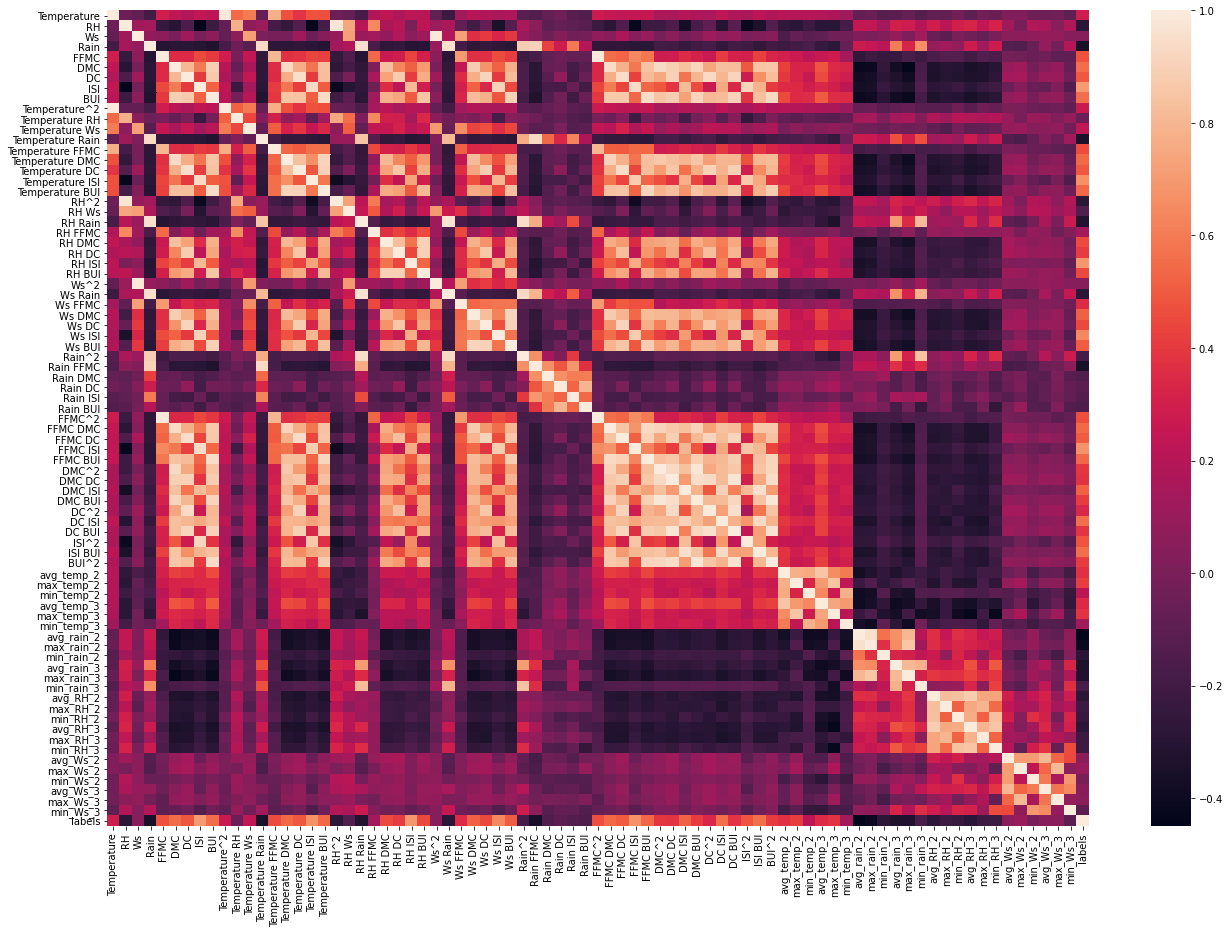

In [47]:
train_data_normalized['labels']=train_labels
train_transformed_corr=train_data_normalized.corr()
plt.figure(figsize=(22,15))
sns.heatmap(train_transformed_corr)
plt.show()
train_data_normalized[train_data_normalized.columns.difference(['Date'])];

### Picking the features which are mostly corelated with the labels

In [48]:
corr_labels=train_transformed_corr[(train_transformed_corr['labels']>0.5) |(train_transformed_corr['labels']<-0.5)]

In [49]:
corr_index=corr_labels.index

In [50]:
corr_index

Index(['DMC', 'ISI', 'BUI', 'Temperature DMC', 'Temperature ISI',
       'Temperature BUI', 'RH ISI', 'Ws DMC', 'Ws ISI', 'Ws BUI', 'FFMC DMC',
       'FFMC DC', 'FFMC ISI', 'FFMC BUI', 'DMC ISI', 'DC ISI', 'ISI BUI',
       'labels'],
      dtype='object')

In [51]:
def transform_corr(data,corr_index):
    """ Getting the data which has features mostly corelated with labels"""
    data_copy=data.copy(deep=True)
    data_copy=data_copy[corr_index]
    data_copy['Date']=data['Date']
    data_copy=data_copy.drop(['labels'],1)
    return data_copy

In [52]:
train_data_corr=transform_corr(train_data_normalized,corr_index)

In [53]:
train_data_corr
train_data_corr['Date']=train_data_normalized['Date']
train_data_corr['Classes']=train_labels

In [54]:
train_data_corr

,DMC,ISI,BUI,Temperature DMC,Temperature ISI,Temperature BUI,RH ISI,Ws DMC,Ws ISI,Ws BUI,FFMC DMC,FFMC DC,FFMC ISI,FFMC BUI,DMC ISI,DC ISI,ISI BUI,Date,Classes
0,-1.403548,-1.044898,-0.818950,-1.207080,-1.005870,-0.906301,-1.093982,-1.223764,-0.949292,-0.800640,-1.171118,-0.526983,-0.961172,-0.753788,-0.732111,-0.719669,-0.756545,01/06/2012,0
1,-1.192354,-1.476594,-1.080362,-1.088270,-1.355650,-0.974697,-1.480690,-1.068506,-1.304231,-0.959977,-1.023893,-1.051212,-1.226703,-0.966562,-0.729080,-0.718049,-0.793608,01/06/2012,0
2,-0.970877,-0.857297,-1.450018,-1.016151,-0.940643,-1.196758,-0.855920,-0.935217,-0.838416,-1.220721,-0.958778,-1.030496,-0.941538,-1.120588,-0.698011,-0.783194,-0.800100,02/06/2012,0
3,-0.836471,-1.318610,-1.221512,-0.864109,-1.169023,-1.103749,-1.512615,-0.693105,-1.198262,-1.076309,-0.941535,-0.947348,-1.085626,-1.046823,-0.748616,-0.744916,-0.774764,02/06/2012,0
4,-1.394242,-1.029254,-1.357575,-1.204345,-0.996633,-1.173690,-0.934364,-1.329047,-0.856665,-1.255211,-1.090167,-0.959621,-1.005250,-1.084928,-0.732705,-0.750744,-0.780449,03/06/2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,1.741640,-0.344281,2.984389,1.998675,-0.206043,3.276750,-0.248928,1.627871,-0.284225,2.674465,2.403281,3.739939,-0.074239,3.807435,0.142539,0.703909,0.586677,26/08/2012,1
174,3.319252,0.790998,3.205489,2.063824,0.308738,1.967414,0.518077,0.830916,-0.201949,0.742645,1.836442,1.285746,0.227364,1.738959,2.471442,2.295668,2.670543,27/08/2012,1
175,1.906340,-0.282907,2.410865,2.425352,-0.070385,2.972030,0.462224,3.481049,0.244174,4.084818,2.138965,3.549549,-0.131118,2.620987,0.260278,0.965079,0.490795,27/08/2012,1
176,1.563031,-0.602125,0.372478,0.746422,-0.689697,-0.047634,-0.824268,0.384600,-0.733599,-0.257942,0.352431,0.866166,-0.757648,-0.253632,-0.169942,0.138241,-0.421841,28/08/2012,0


#### Training the models on data obtained from choosing features selected from mostly corelated with labels

In [55]:
def K_fold_split_corr(data):
    K_corr=[]
    for i in range(len(train_start_dates_1)):
            # For features obtained from corr
            train_corr,val_corr=cv_split(data,train_start_dates_1[i],train_end_dates_1[i],val_start_date[i],val_end_date[i],train_start_dates_2[i],train_end_dates_2[i])
            K_corr.append([train_corr,val_corr])
    return K_corr

In [56]:
def train_models_corr(data,Model,Model_str,hidden_layer_size=(50)):
    np.warnings.filterwarnings('ignore')
    K_split_corr=K_fold_split_corr(data)
    accuracy,f1,mean_f1=Models_train(K_split_corr,Model,Hidden_layer_sizes= hidden_layer_size)
    print("The accuracy and mean F1 score for with {0} Model for data selection using corelation with labels is {1} and {2} ".format(Model_str,accuracy,mean_f1))

#### Training the Perceptron on data obtained from choosing features which has most corelation with labels

In [57]:
train_models_corr(train_data_corr,Perceptron,'Perceptron')

The accuracy and mean F1 score for with Perceptron Model for data selection using corelation with labels is 83.49019607843138 and 0.7491373766458165 


#### Training the Logistic Regression (with varying regularization) on data obtained from choosing features which has most corelation with labels

In [58]:
def train_models_corr_logistic_knn(data,Model,Model_str):
    np.warnings.filterwarnings('ignore')
    if Model!=KNeighborsClassifier:
        C_list=[0.05, 0.1, 0.7, 1,5,10]
    else:
        C_list=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    for c in C_list:
        K_split_corr=K_fold_split_corr(data)
        accuracy,f1,mean_f1=Models_train(K_split_corr,Model,no_of_neighbours=c)
        if Model!=KNeighborsClassifier:
            print("The accuracy and mean F1 score for with {0} Model with C as {1} for data selection using corelation with labels is {2} and {3} ".format(Model_str,c,accuracy,mean_f1))
        else:
            print("The accuracy and mean F1 score for with {0} Model with No.of neighbours as {1} for data selection using corelation with labels is {2} and {3} ".format(Model_str,c,accuracy,mean_f1))

In [59]:
train_models_corr_logistic_knn(train_data_corr,LogisticRegression,'Logistic Regression')

The accuracy and mean F1 score for with Logistic Regression Model with C as 0.05 for data selection using corelation with labels is 91.41176470588235 and 0.8816758241758242 
The accuracy and mean F1 score for with Logistic Regression Model with C as 0.1 for data selection using corelation with labels is 91.41176470588235 and 0.8816758241758242 
The accuracy and mean F1 score for with Logistic Regression Model with C as 0.7 for data selection using corelation with labels is 91.41176470588235 and 0.8816758241758242 
The accuracy and mean F1 score for with Logistic Regression Model with C as 1 for data selection using corelation with labels is 91.41176470588235 and 0.8816758241758242 
The accuracy and mean F1 score for with Logistic Regression Model with C as 5 for data selection using corelation with labels is 91.41176470588235 and 0.8816758241758242 
The accuracy and mean F1 score for with Logistic Regression Model with C as 10 for data selection using corelation with labels is 91.41176

#### Training the Bayes Classifier on data obtained from choosing features which has most corelation with labels

In [60]:
train_models_corr(train_data_corr,GaussianNB,'Bayes Classifier')

The accuracy and mean F1 score for with Bayes Classifier Model for data selection using corelation with labels is 91.41176470588235 and 0.8788704335658621 


#### Training KNN by varying the number of neighbours on data obtained from choosing features which has most corelation with labels

In [61]:
train_models_corr_logistic_knn(train_data_corr,KNeighborsClassifier,'K Nearest Neighbors')

The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 3 for data selection using corelation with labels is 92.74509803921568 and 0.906922891922892 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 4 for data selection using corelation with labels is 90.74509803921569 and 0.889196155062979 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 5 for data selection using corelation with labels is 92.82352941176471 and 0.8837990297096523 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 6 for data selection using corelation with labels is 90.8235294117647 and 0.864287846448469 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 7 for data selection using corelation with labels is 91.49019607843138 and 0.8698923992673994 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.

#### Training Random Forests on data obtained from choosing features which has most corelation with labels

In [62]:
train_models_corr(train_data_corr, RandomForestClassifier,'Random Forests')

The accuracy and mean F1 score for with Random Forests Model for data selection using corelation with labels is 90.8235294117647 and 0.863601567550097 


#### Training Neural Network with various architectures on data obtained from choosing features which has most corelation with labels

##### Architecture of 1 hidden layer with 40 units in the hidden layer

In [63]:
train_models_corr(train_data_corr,MLPClassifier,'Neural Network')

The accuracy and mean F1 score for with Neural Network Model for data selection using corelation with labels is 92.15686274509804 and 0.8768704212454212 


##### Architecture of 2 hidden layers with (50,10)  units in the hidden layer

In [64]:
train_models_corr(train_data_corr,MLPClassifier,'Neural Network',(50,10))

The accuracy and mean F1 score for with Neural Network Model for data selection using corelation with labels is 87.5686274509804 and 0.8185678356730989 


##### Architecture of 2 hidden layers with (35,15)  units in the hidden layer

In [65]:
train_models_corr(train_data_corr,MLPClassifier,'Neural Network',(35,15))

The accuracy and mean F1 score for with Neural Network Model for data selection using corelation with labels is 87.5686274509804 and 0.8213407626451106 


#### Training the Ridge Classifier on data obtained from choosing mostly corelated features with labels 

In [66]:
train_models_corr(train_data_corr,RidgeClassifier,'Ridge Classifier')

The accuracy and mean F1 score for with Ridge Classifier Model for data selection using corelation with labels is 91.49019607843137 and 0.871055645062998 


#### Training the SVM with Linear, polynomial Kernel and RBF Kernel on data obtained from choosing mostly corelated features with labels for various values of C (regularization) and Gamma (Kernel coefficient)

In [67]:
def train_models_SVM_corr(data):
    np.warnings.filterwarnings('ignore')
    g_list=[0.0001,0.0005,0.001,0.01,0.1,1]
    C_list=[0.0001,0.001,0.01,0.1,1,10,100,500]
    Kernel_list=['linear','poly','rbf']
    accuracy_max=0
    f1_max=0
    c_max=0
    gamma_max=0
    kernel_max=0
    K_split_corr=K_fold_split_corr(data)
    for kernel in Kernel_list:
        for gamma in g_list:
            for c in C_list:
                accuracy,f1,mean_f1=Models_train(K_split_corr,SVC,Kernel=kernel,C_val=c,Gamma=gamma)
                print("The accuracy for with {0} Kernel for gamma as {1} and C as {2} is {3}".format(kernel,gamma,c,accuracy))
                if(accuracy>accuracy_max):
                    accuracy_max=accuracy
                    c_max=c
                    gamma_max=gamma
                    kernel_max=kernel
                    f1_max=mean_f1
    print("The maximum accuracy using SVM is obtained using {0} Kernel with C as {1} and gamma as {2}. The accuracy is {3} and corresponding f1 score is {4}".format(kernel_max,c_max,gamma_max,accuracy_max,f1_max))

In [68]:
train_models_SVM_corr(train_data_corr)

The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.001 is 65.56862745098039
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.01 is 92.82352941176471
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.1 is 91.49019607843138
The accuracy for with linear Kernel for gamma as 0.0001 and C as 1 is 90.15686274509805
The accuracy for with linear Kernel for gamma as 0.0001 and C as 10 is 88.23529411764707
The accuracy for with linear Kernel for gamma as 0.0001 and C as 100 is 86.15686274509804
The accuracy for with linear Kernel for gamma as 0.0001 and C as 500 is 84.82352941176471
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.001 is 65.56862745098039
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.01 is 92.82352941176471
The

The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.01 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.1 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 1 is 65.56862745098039
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 10 is 92.82352941176471
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 100 is 91.49019607843138
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 500 is 90.15686274509805
The accuracy for with rbf Kernel for gamma as 0.001 and C as 0.0001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.001 and C as 0.001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.001 and C as 0.01 is 62.8235294117647
The accuracy for with rbf Kernel for gamma a

### Feature selection and reduction - Picking the subset Using Sequential Feature Selection- Fitting on logistic regression

In [69]:
train_data_normalized_copy=train_data_normalized.copy(deep=True)
train_data_normalized_copy=train_data_normalized_copy.drop(['labels','Date'],axis=1)

In [70]:
sfs=SequentialFeatureSelector(LogisticRegression(),n_features_to_select= 7)
train_data_sfs=sfs.fit_transform(train_data_normalized_copy,train_labels)
indices=sfs.get_support(indices=True)

In [71]:
# Getting most important indices of features selected by SFS
indices

array([ 7, 19, 20, 22, 33, 38, 44])

In [72]:
train_data_sfs=pd.DataFrame(train_data_sfs)
train_data_sfs['Date']=train_data_normalized['Date']
train_data_sfs['Classes']=train_labels

In [73]:
train_data_sfs

,0,1,2,3,4,5,6,Date,Classes
0,-1.044898,-0.844704,-0.367403,-1.251213,-0.154096,-0.490634,-0.635681,01/06/2012,0
1,-1.476594,-0.539484,-0.001081,-1.096899,-0.124317,-0.095823,-0.643559,01/06/2012,0
2,-0.857297,-0.663829,0.227118,-0.882095,-0.082735,-0.726006,-0.627160,02/06/2012,0
3,-1.318610,1.756384,2.208651,-0.480124,0.449727,-0.245529,-0.604898,02/06/2012,0
4,-1.029254,3.185451,8.503140,-1.413270,6.806092,-2.693584,-0.636512,03/06/2012,0
...,...,...,...,...,...,...,...,...,...
173,-0.344281,-0.017324,-0.199723,1.775506,-0.157047,0.888484,1.621832,26/08/2012,1
174,0.790998,-1.284873,-0.181579,2.233082,-0.154402,1.755741,4.671661,27/08/2012,1
175,-0.282907,3.102093,-0.106115,3.876822,-0.155626,1.121547,1.880341,27/08/2012,1
176,-0.602125,-1.325709,-0.180859,0.422784,-0.151035,0.700651,1.357271,28/08/2012,0


#### Training models on features obtained from SFS

In [74]:
def K_fold_split_sfs(data):
    K_sfs=[]
    for i in range(len(train_start_dates_1)):
            # For features obtained from corr
            train_corr,val_corr=cv_split(data,train_start_dates_1[i],train_end_dates_1[i],val_start_date[i],val_end_date[i],train_start_dates_2[i],train_end_dates_2[i])
            K_sfs.append([train_corr,val_corr])
    return K_sfs

In [75]:
def train_models_sfs(data,Model,Model_str,hidden_layer_size=(50)):
    np.warnings.filterwarnings('ignore')
    K_split_sfs=K_fold_split_sfs(data)
    accuracy,f1,mean_f1=Models_train(K_split_sfs,Model,Hidden_layer_sizes= hidden_layer_size)
    print("The accuracy and mean F1 score for with {0} Model for data selected using SFS is {1} and {2} ".format(Model_str,accuracy,mean_f1))

#### Training Linear Perceptron on data obtained from Sequential Feature Selection

In [76]:
train_models_sfs(train_data_sfs,Perceptron,'Perceptron')

The accuracy and mean F1 score for with Perceptron Model for data selected using SFS is 82.23529411764707 and 0.7540055583533845 


### Training the Logistic Regression (with varying regularization) on data obtained from SFS

In [77]:
def train_models_sfs_logistic_knn(data,Model,Model_str):
    np.warnings.filterwarnings('ignore')
    if Model!=KNeighborsClassifier:
        C_list=[0.05, 0.1, 0.7, 1,5,10]
    else:
        C_list=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    for c in C_list:
        K_split_sfs=K_fold_split_sfs(data)
        accuracy,f1,mean_f1=Models_train(K_split_sfs,Model,no_of_neighbours=c)
        if Model!=KNeighborsClassifier:
            print("The accuracy and mean F1 score for with {0} Model with C as {1} for data selection using SFS is {2} and {3} ".format(Model_str,c,accuracy,mean_f1))
        else:
            print("The accuracy and mean F1 score for with {0} Model with No.of neighbours as {1} for data selection using SFS is {2} and {3} ".format(Model_str,c,accuracy,mean_f1))

In [78]:
train_models_sfs_logistic_knn(train_data_sfs,LogisticRegression,'Logistic Regression')

The accuracy and mean F1 score for with Logistic Regression Model with C as 0.05 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 
The accuracy and mean F1 score for with Logistic Regression Model with C as 0.1 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 
The accuracy and mean F1 score for with Logistic Regression Model with C as 0.7 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 
The accuracy and mean F1 score for with Logistic Regression Model with C as 1 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 
The accuracy and mean F1 score for with Logistic Regression Model with C as 5 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 
The accuracy and mean F1 score for with Logistic Regression Model with C as 10 for data selection using SFS is 90.8235294117647 and 0.8638682234947714 


#### Training the Bayes Classifier on data obtained from choosing features with SFS

In [79]:
train_models_sfs(train_data_sfs,GaussianNB,'Bayes Classifier')

The accuracy and mean F1 score for with Bayes Classifier Model for data selected using SFS is 88.74509803921569 and 0.8429383324729702 


#### Training KNN by varying the number of neighbours on data obtained from SFS

In [80]:
train_models_sfs_logistic_knn(train_data_sfs,KNeighborsClassifier,'K Nearest Neighbors')

The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 3 for data selection using SFS is 88.23529411764707 and 0.8300949257141208 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 4 for data selection using SFS is 86.98039215686275 and 0.8157071080054952 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 5 for data selection using SFS is 88.90196078431373 and 0.8369834087481147 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 6 for data selection using SFS is 88.31372549019608 and 0.8291751214735086 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 7 for data selection using SFS is 88.90196078431373 and 0.8373626373626374 
The accuracy and mean F1 score for with K Nearest Neighbors Model with No.of neighbours as 8 for data selection using SFS is 87.64705882352942 and 0.8222156457640328

#### Training Random Forests on data obtained from SFS

In [81]:
train_models_sfs(train_data_sfs,RandomForestClassifier,'Random Forests Classifier')

The accuracy and mean F1 score for with Random Forests Classifier Model for data selected using SFS is 88.15686274509804 and 0.8354426589848606 


#### Training Neural Network with various architectures on data obtained from SFS

##### Architecture of 1 hidden layer with 40 units in the hidden layer

In [82]:
train_models_sfs(train_data_sfs,MLPClassifier,'Neural Network')

The accuracy and mean F1 score for with Neural Network Model for data selected using SFS is 91.49019607843137 and 0.8700398351648351 


##### Architecture of 2 hidden layers with (50,10) units in the hidden layer

In [83]:
train_models_sfs(train_data_sfs,MLPClassifier,'Neural Network',hidden_layer_size=(50,10))

The accuracy and mean F1 score for with Neural Network Model for data selected using SFS is 88.15686274509804 and 0.8363156748578764 


##### Architecture of 2 hidden layers with (30,10) units in the hidden layer

In [84]:
train_models_sfs(train_data_sfs,MLPClassifier,'Neural Network',hidden_layer_size=(30,10))

The accuracy and mean F1 score for with Neural Network Model for data selected using SFS is 90.23529411764706 and 0.8522647014514022 


#### Training the Ridge Classifier on data obtained from SFS

In [85]:
train_models_sfs(train_data_sfs,RidgeClassifier,'Ridge Classifier')

The accuracy and mean F1 score for with Ridge Classifier Model for data selected using SFS is 88.47058823529412 and 0.8458875146329774 


#### Training the SVM with Linear, polynomial Kernel and RBF Kernel on data obtained from SFS for various values of C (regularization) and Gamma (Kernel coefficient)

In [86]:
def train_models_SVM_sfs(data):
    np.warnings.filterwarnings('ignore')
    g_list=[0.0001,0.0005,0.001,0.01,0.1,1]
    C_list=[0.0001,0.001,0.01,0.1,1,10,100,500]
    Kernel_list=['linear','poly','rbf']
    accuracy_max=0
    f1_max=0
    c_max=0
    gamma_max=0
    kernel_max=0
    K_split_sfs=K_fold_split_sfs(data)
    for kernel in Kernel_list:
        for gamma in g_list:
            for c in C_list:
                accuracy,f1,mean_f1=Models_train(K_split_sfs,SVC,Kernel=kernel,C_val=c,Gamma=gamma)
                print("The accuracy for with {0} Kernel for gamma as {1} and C as {2} is {3}".format(kernel,gamma,c,accuracy))
                if(accuracy>accuracy_max):
                    accuracy_max=accuracy
                    c_max=c
                    gamma_max=gamma
                    kernel_max=kernel
                    f1_max=mean_f1
    print("The maximum accuracy using SVM is obtained using {0} Kernel with C as {1} and gamma as {2}. The accuracy is {3} and corresponding f1 score is {4}".format(kernel_max,c_max,gamma_max,accuracy_max,f1_max))

In [87]:
train_models_SVM_sfs(train_data_sfs)

The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.0001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.01 is 74.90196078431373
The accuracy for with linear Kernel for gamma as 0.0001 and C as 0.1 is 92.23529411764707
The accuracy for with linear Kernel for gamma as 0.0001 and C as 1 is 92.82352941176471
The accuracy for with linear Kernel for gamma as 0.0001 and C as 10 is 90.90196078431372
The accuracy for with linear Kernel for gamma as 0.0001 and C as 100 is 90.8235294117647
The accuracy for with linear Kernel for gamma as 0.0001 and C as 500 is 90.8235294117647
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.001 is 62.8235294117647
The accuracy for with linear Kernel for gamma as 0.0005 and C as 0.01 is 74.90196078431373
The acc

The accuracy for with rbf Kernel for gamma as 0.0001 and C as 1 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0001 and C as 10 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0001 and C as 100 is 89.5686274509804
The accuracy for with rbf Kernel for gamma as 0.0001 and C as 500 is 92.23529411764707
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.0001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.001 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.01 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 0.1 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 1 is 62.8235294117647
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 10 is 73.56862745098039
The accuracy for with rbf Kernel for gamma as 0.0005 and C as 100 is 92.23529411764707
The accuracy for with rbf Kernel for gamma as 0.000

### Finally, the best performing model after Model Selection is SVM (Linear Kernel) with C (regularization parameter) as 0.01, gamma as 0.0001 on the data obtained from choosing the mostly corelated features with labels. The accuracy on validation set is 92.823 % and the mean F1 score is 0.8854

## Testing the best performing model on the test set

In [88]:
test_data_corr=test_data_normalized.copy(deep=True)
test_data_corr['labels']=test_labels
test_data_corr=test_data_corr[corr_index]
test_data_corr=test_data_corr.drop(['labels'],1)

In [89]:
train_data_corr_copy=train_data_corr.copy(deep=True)
svc=SVC(kernel='linear',C=0.01,gamma=0.0001)
svc.fit(train_data_corr_copy.drop(['Classes','Date'],1),train_labels)

SVC(C=0.01, gamma=0.0001, kernel='linear')

In [90]:
test_pred_final=svc.predict(test_data_corr)
print("The accuracy obtained on the test set with best performing model on the validation set is {0}".format(accuracy_score(test_pred_final,test_labels)*100))
print("The F1 scores of each label obtained on the test set with best performing model on the validation set is {0} ".format(f1_score(test_pred_final,test_labels,average=None)))
print("The Mean F1 score obtained on the test set with best performing model on the validation set is {0} ".format(np.mean(f1_score(test_pred_final,test_labels,average=None))))
conf_matirx_test=confusion_matrix(test_pred_final,test_labels)


The accuracy obtained on the test set with best performing model on the validation set is 81.66666666666667
The F1 scores of each label obtained on the test set with best performing model on the validation set is [0.82539683 0.80701754] 
The Mean F1 score obtained on the test set with best performing model on the validation set is 0.8162071846282373 


The Confusion Matrix obtained on the test set with best performing model on the validation set


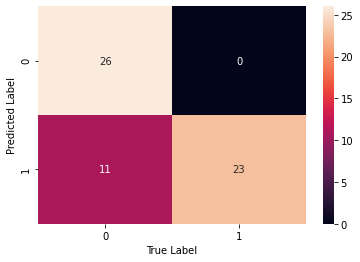

In [91]:
print("The Confusion Matrix obtained on the test set with best performing model on the validation set")
ax=sns.heatmap(conf_matirx_test,annot=True)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## Testing the trivial model on the test set

In [143]:
def trivial_system_classifier(train_labels,test_labels):
    """ Function to perform the trivial system classification"""
    unique_values, no_of_unique=np.unique(test_labels,return_counts=True)
    pred_labels=random.choices([0,1],weights=[(no_of_unique[0]/len(train_labels)),(no_of_unique[1]/len(train_labels))],k=len(test_labels))
    return accuracy_score(test_labels,pred_labels)*100, f1_score(test_labels,pred_labels),np.mean(f1_score(test_labels,pred_labels)),pred_labels
train_data_before_dropping_rows,train_labels_before_dropping=read_data("algerian_fires_train.csv")

In [144]:
accuracy_score_trivial,f1_score_trivial,mean_f1_trivial,pred_labels=trivial_system_classifier(train_labels_before_dropping,test_labels)

The accuracy obtained on the test set with trivial model is 45.0
The F1 scores of each label obtained on the test set with trivial model is 0.1951219512195122 
The Mean F1 score obtained on the test set with trivial model is 0.1951219512195122 
The Confusion Matrix obtained on the test set with trivial model


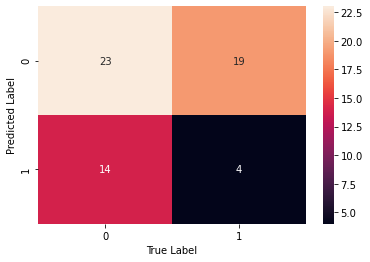

In [145]:
print("The accuracy obtained on the test set with trivial model is {0}".format(accuracy_score_trivial))
print("The F1 scores of each label obtained on the test set with trivial model is {0} ".format(f1_score_trivial))
print("The Mean F1 score obtained on the test set with trivial model is {0} ".format(np.mean(mean_f1_trivial)))
conf_matirx_test_trivial=confusion_matrix(pred_labels,test_labels)
print("The Confusion Matrix obtained on the test set with trivial model")
ax=sns.heatmap(conf_matirx_test_trivial,annot=True)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## Testing the baseline model on the test set

##### Coding up the Nearest Means Classifier

In [99]:
def Nearest_means_train(train_data_values,input_data_labels):
    """ Function to calculate Class means for training data"""
    indices_class_1=[]
    indices_class_2=[]
    #Getting indices for each class
    for i in range(len(input_data_labels)):
        if(input_data_labels[i]==0):
            indices_class_1.append(i)
        elif(input_data_labels[i]==1):
            indices_class_2.append(i)
    #Getting values for that indices which belongs to that class
    class_1_values=train_data_values.iloc[indices_class_1]
    class_2_values=train_data_values.iloc[indices_class_2]
    #Finding mean for each class
    class_1_mean=(np.mean(class_1_values,axis=0))
    class_2_mean=(np.mean(class_2_values,axis=0))
    #Returning the mean co-ordinates for each class    
    return class_1_mean,class_2_mean

def prediction_nearest_means(values,mean_list):
    """ Predictions based on nearest means"""
    labels_classified=[]
    for i in range(len(values)):
        if(np.linalg.norm(values.loc[i]-mean_list[0])<np.linalg.norm(values.loc[i]-mean_list[1])):
            labels_classified.append(0)
        else:
            labels_classified.append(1)
    return labels_classified

In [100]:
train_data_copy=train_data.copy(deep=True).drop(['Date'],axis=1)
test_data_copy=test_data.copy(deep=True).drop(['Date'],axis=1)

In [101]:
class_1_mean,class_2_mean=Nearest_means_train(train_data_copy,train_labels_before_dropping)
pred_baseline=prediction_nearest_means(test_data_copy,[class_1_mean,class_2_mean])

In [105]:
accuracy_score_baseline=accuracy_score(pred_baseline,pred_labels)*100
f1_score_baseline=f1_score(pred_baseline,test_labels,average=None)
mean_f1_baseline=np.mean(f1_score(pred_baseline,test_labels))


The accuracy obtained on the test set with baseline model is 61.66666666666667
The F1 scores of each label obtained on the test set with baseline model is [0.84705882 0.62857143] 
The Mean F1 score obtained on the test set with baseline model is 0.6285714285714286 
The Confusion Matrix obtained on the test set with baseline model


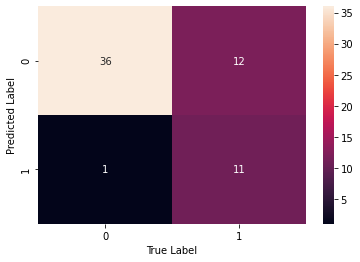

In [106]:
print("The accuracy obtained on the test set with baseline model is {0}".format(accuracy_score_baseline))
print("The F1 scores of each label obtained on the test set with baseline model is {0} ".format(f1_score_baseline))
print("The Mean F1 score obtained on the test set with baseline model is {0} ".format(np.mean(mean_f1_baseline)))
conf_matirx_test_baseline=confusion_matrix(pred_baseline,test_labels)
print("The Confusion Matrix obtained on the test set with baseline model")
sns.heatmap(conf_matirx_test_baseline,annot=True)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()